In [1]:
import run_benchmark
import pandas as pd
import numpy as np
from ast import literal_eval
import random
from itertools import combinations

In [2]:
benchmark_results = run_benchmark.benchmark_all_models(run_benchmark.models, run_benchmark.ground_truth_dir)
best_model = benchmark_results['Qwen3-30B-A3B']



[1/7] Evaluating Qwen3-30B-A3B...
  ✓ Macro F1: 0.7648

[2/7] Evaluating Qwen3-4B...
  ✓ Macro F1: 0.6546

[3/7] Evaluating Qwen2.5-32B...
  ✓ Macro F1: 0.6726

[4/7] Evaluating Qwen2.5-72B...
  ✓ Macro F1: 0.6227

[5/7] Evaluating Llama-3.3-70B...
  ✓ Macro F1: 0.6064

[6/7] Evaluating Gemma-3-4B...
  ✓ Macro F1: 0.3172

[7/7] Evaluating Gemma-3-27B...
  ✓ Macro F1: 0.6292


In [3]:
def get_predicion_items(df, annotator_threshold=1):
    tp, fp, fn = 0, 0, 0
    for _, row in df.iterrows():
        # Convert 'annotators' to a list of ints if possible, or handle "ground_truth" as special case
        annotators = row['annotators']
        if isinstance(annotators, str):
            if annotators == "ground_truth":
                annotator_count = 0
            else:
                # Try to eval string representation of list, e.g. "[1,2]"
                try:
                    annotator_list = eval(annotators)
                    if isinstance(annotator_list, list):
                        annotator_count = len(annotator_list)
                    else:
                        annotator_count = 0
                except Exception:
                    annotator_count = 0
        elif isinstance(annotators, list):
            annotator_count = len(annotators)
        else:
            annotator_count = 0

        if annotator_count >= annotator_threshold:
            if row['is_correct']:
                tp += 1
            else:
                if row['best_match_info'] != "false_negative":
                    fp+= 1
        else:
            if annotator_count == 0 and row['best_match_info'] == "false_negative":
                fn += 1
    return tp, fp, fn


def get_predicion_items_strict(df, annotator_agreements):
    tp, fp, fn = 0, 0, 0
    for _, row in df.iterrows():
        # Strict annotator agreement: Only count if all annotators in annotator_agreements are present in the annotator list
        annotator_count = 0
        annotators = row['annotators']
        if isinstance(annotators, str) and annotators != "ground_truth":
            try:
                annotator_list = literal_eval(annotators)
                if isinstance(annotator_list, list):
                    # Check if all required annotators are present
                    for a in annotator_agreements:
                        if a in annotator_list:
                            annotator_count += 1
                else:
                    annotator_count = 0
            except Exception:
                annotator_count = 0
        elif isinstance(annotators, list):
            for a in annotator_agreements:
                if a in annotators:
                    annotator_count += 1
        
        # This is where the value (e.g., tp, fp, fn) gets incremented if the annotator_count meets the strict agreement threshold
        if annotator_count >= len(annotator_agreements):
            if row['is_correct']:
                tp += 1
            else:
                if row['best_match_info'] == "false_positive":
                    fp += 1
        
        if row['best_match_info'] == "false_negative":
                fn += 1

    return tp, fp, fn
        

def compute_precision_recall_f1(tp, fp, fn):
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1

In [4]:
def compute_doc_f1(df, annotator_threshold=None, strict_pair=None):
    if strict_pair:
        tp, fp, fn = get_predicion_items_strict(df, strict_pair)
    else:
        tp, fp, fn = get_predicion_items(df, annotator_threshold)
    return compute_precision_recall_f1(tp, fp, fn)

# ————————————————————————————————————————————————————————————————
# 3) Paired bootstrap for ΔF1
def bootstrap_delta_f1(df, params_A, params_B, doc_col='Document ID', B=1000, seed=0):
    # reference ΔF1
    f1_A_ref = compute_doc_f1(df, **params_A)
    f1_B_ref = compute_doc_f1(df, **params_B)
    delta_ref = f1_B_ref - f1_A_ref

    docs = df[doc_col].unique()
    rng = random.Random(seed)
    deltas = []
    for _ in range(B):
        sampled = [rng.choice(docs) for _ in docs]
        df_s = df[df[doc_col].isin(sampled)]
        f1_A = compute_doc_f1(df_s, **params_A)
        f1_B = compute_doc_f1(df_s, **params_B)
        # centered difference
        deltas.append((f1_B - f1_A) - delta_ref)

    lo, hi = np.percentile(deltas, [2.5, 97.5])
    return delta_ref + lo, delta_ref + hi

In [5]:
# Macro over entity types (pooled across documents), no document averaging

def _get_entity_type(row):
    return row.get('Entity Type', row.get('entity_type', row.get('type', 'unknown')))


def compute_macro_over_types_f1(df, annotator_threshold=1):
    per_type_counts = {}
    for _, row in df.iterrows():
        t = _get_entity_type(row)
        if t not in per_type_counts:
            per_type_counts[t] = {'tp': 0, 'fp': 0, 'fn': 0}

        # threshold voting on annotator count
        annotators = row['annotators']
        if isinstance(annotators, str):
            if annotators == "ground_truth":
                annotator_count = 0
            else:
                try:
                    annotator_list = eval(annotators)
                    annotator_count = len(annotator_list) if isinstance(annotator_list, list) else 0
                except Exception:
                    annotator_count = 0
        elif isinstance(annotators, list):
            annotator_count = len(annotators)
        else:
            annotator_count = 0

        if annotator_count >= annotator_threshold:
            if row['is_correct']:
                per_type_counts[t]['tp'] += 1
            else:
                if row['best_match_info'] != "false_negative":
                    per_type_counts[t]['fp'] += 1
        else:
            if annotator_count == 0 and row['best_match_info'] == "false_negative":
                per_type_counts[t]['fn'] += 1

    if not per_type_counts:
        return 0.0

    per_type_f1 = []
    for c in per_type_counts.values():
        per_type_f1.append(compute_precision_recall_f1(c['tp'], c['fp'], c['fn']))

    return sum(per_type_f1) / len(per_type_f1)


def compute_macro_over_types_strict_f1(df, annotator_agreements):
    per_type_counts = {}
    for _, row in df.iterrows():
        t = _get_entity_type(row)
        if t not in per_type_counts:
            per_type_counts[t] = {'tp': 0, 'fp': 0, 'fn': 0}

        # count presence of required annotators
        annotator_count = 0
        annotators = row['annotators']
        if isinstance(annotators, str) and annotators != "ground_truth":
            try:
                annotator_list = literal_eval(annotators)
                if isinstance(annotator_list, list):
                    for a in annotator_agreements:
                        if a in annotator_list:
                            annotator_count += 1
            except Exception:
                annotator_count = 0
        elif isinstance(annotators, list):
            for a in annotator_agreements:
                if a in annotators:
                    annotator_count += 1

        # Strict: only count TP/FP when all required annotators present
        if annotator_count >= len(annotator_agreements):
            if row['is_correct']:
                per_type_counts[t]['tp'] += 1
            else:
                if row['best_match_info'] == "false_positive":
                    per_type_counts[t]['fp'] += 1

        # Always count FN for missed ground truth
        if row['best_match_info'] == "false_negative":
            per_type_counts[t]['fn'] += 1

    if not per_type_counts:
        return 0.0

    per_type_f1 = []
    for c in per_type_counts.values():
        per_type_f1.append(compute_precision_recall_f1(c['tp'], c['fp'], c['fn']))

    return sum(per_type_f1) / len(per_type_f1)


# Override: compute_doc_f1 now returns macro F1 over entity types (pooled across documents)

def compute_doc_f1(df, annotator_threshold=None, strict_pair=None):
    if strict_pair:
        return compute_macro_over_types_strict_f1(df, strict_pair)
    else:
        return compute_macro_over_types_f1(df, annotator_threshold)


In [6]:
print(best_model.keys())
df = best_model['results_df']

filters = [
    ("Any ≥1",        {'annotator_threshold': 1, 'strict_pair': None}),
    ("Majority ≥2",   {'annotator_threshold': 2, 'strict_pair': None}),
    ("Unanimous 3/3", {'annotator_threshold': 3, 'strict_pair': None}),
    ("Pair [0,2]",    {'annotator_threshold': None, 'strict_pair': (0,2)}),
]

results = []
for (nameA, paramsA), (nameB, paramsB) in combinations(filters, 2):
    lo, hi = bootstrap_delta_f1(df, paramsA, paramsB, doc_col='Document ID', B=1000, seed=42)
    delta = compute_doc_f1(df, **paramsB) - compute_doc_f1(df, **paramsA)
    results.append({
        'Comparison': f"{nameB} vs {nameA}",
        'ΔF1':          delta,
        '95% CI Low':   lo,
        '95% CI High':  hi,
    })

print(pd.DataFrame(results))

dict_keys(['overall', 'per_entity_type', 'results_df', 'unmatched_gt_info'])
                     Comparison     ΔF1  95% CI Low  95% CI High
0         Majority ≥2 vs Any ≥1  0.0331      0.0188       0.0440
1       Unanimous 3/3 vs Any ≥1  0.0289      0.0085       0.0452
2          Pair [0,2] vs Any ≥1  0.0279      0.0088       0.0431
3  Unanimous 3/3 vs Majority ≥2 -0.0042     -0.0178       0.0077
4     Pair [0,2] vs Majority ≥2 -0.0052     -0.0168       0.0053
5   Pair [0,2] vs Unanimous 3/3 -0.0010     -0.0077       0.0064


In [ ]:
df_results = pd.DataFrame(results, columns=["Comparison", "ΔF1", "95% CI Low", "95% CI High"])

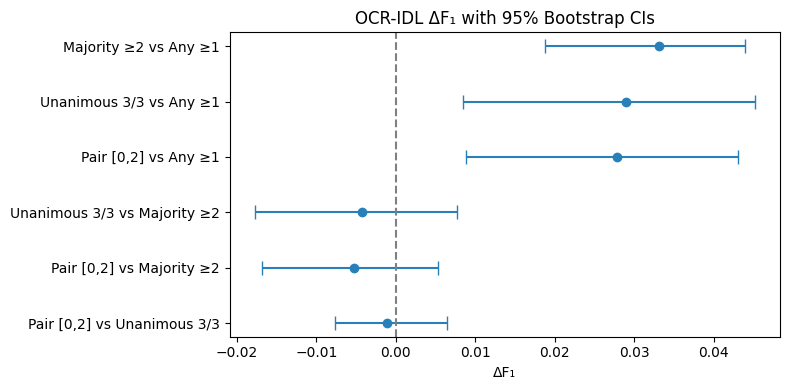

In [8]:
# df_results = pd.DataFrame(results)

import matplotlib.pyplot as plt

# Compute asymmetric error bars
deltas    = df_results['ΔF1']
err_lower = deltas - df_results['95% CI Low']
err_upper = df_results['95% CI High'] - deltas

# Reverse order for plotting top‐to‐bottom
y_positions = list(range(len(df_results), 0, -1))

fig, ax = plt.subplots(figsize=(8, 4))
ax.errorbar(
    deltas,
    y_positions,
    xerr=[err_lower, err_upper],
    fmt='o',
    capsize=5,
    color='#2980b9',
)
ax.axvline(0, color='gray', linestyle='--')    # no-difference line
ax.set_yticks(y_positions)
ax.set_yticklabels(df_results['Comparison'])
ax.set_xlabel('ΔF₁')
ax.set_title('OCR-IDL ΔF₁ with 95% Bootstrap CIs')
plt.tight_layout()
plt.savefig('OCR-IDL_ΔF1.png', dpi=600)
plt.show()